In [1]:
import time
from datetime import datetime
import vectorbt as vbt
from tqdm import tqdm

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('USDJPY_1h.csv')
data.tail()

,timestamp,open,high,low,close,adj close,volumn
4984,2022-08-30 13:00:00+01:00,138.197998,138.501007,138.160004,138.492996,138.492996,0
4985,2022-08-30 14:00:00+01:00,138.490997,138.561005,138.139999,138.386002,138.386002,0
4986,2022-08-30 15:00:00+01:00,138.382996,139.080002,138.360001,138.886002,138.886002,0
4987,2022-08-30 16:00:00+01:00,138.884995,138.955994,138.580002,138.727997,138.727997,0
4988,2022-08-30 17:00:00+01:00,138.725998,138.772995,138.619995,138.690994,138.690994,0


In [3]:
df = data.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
df.set_index('timestamp', inplace = True)
df

,open,high,low,close,adj close,volumn
timestamp,,,,,,
2021-11-04 17:00:00,113.750000,113.750999,113.620003,113.680000,113.680000,0
2021-11-04 18:00:00,113.680000,113.740997,113.639999,113.738998,113.738998,0
2021-11-04 19:00:00,113.737000,113.787003,113.669998,113.702003,113.702003,0
2021-11-04 20:00:00,113.700996,113.779999,113.680000,113.746002,113.746002,0
2021-11-04 21:00:00,113.733002,113.769997,113.692001,113.740997,113.740997,0
...,...,...,...,...,...,...
2022-08-30 12:00:00,138.197998,138.501007,138.160004,138.492996,138.492996,0
2022-08-30 13:00:00,138.490997,138.561005,138.139999,138.386002,138.386002,0
2022-08-30 14:00:00,138.382996,139.080002,138.360001,138.886002,138.886002,0


In [4]:
def find_peak(price, i, order, K=6):
    # max_idx, min_idx ใช้หาจุดสูงสุด/ต่ำสุดสัมพัทธ์ทั้งหมดได้ผลออกมาเป็น list , order คือค่า sampling
    max_idx = list(argrelextrema(price.values[:i], np.greater, order=order)[0])
    min_idx = list(argrelextrema(price.values[:i], np.less, order=order)[0])

    idx = max_idx + min_idx + [len(price.values[:i]) - 1] # รวม index ของค่าจุดสูงสุด/ต่ำสุดกับราคาล่าสุดเป็น list
    idx.sort()  # เรียงลำดับเลข index จากน้อยไปมาก
    current_idx = idx[-K:] # เลือกจุดสูงสุด/ต่ำสุด K จุดล่าสุด
    
    start = min(current_idx) # index เริ่มต้นของค่าจุดสูงสุด/ต่ำสุด
    end = max(current_idx)  # index สุดท้ายของค่าจุดสูงสุด/ต่ำสุด
    
    current_pat = price.values[current_idx] # list ของค่าจุดสูงสุด/ต่ำสุด
    
    return current_pat, current_idx, start, end

In [5]:
def find_trend(current_pat):
    if len(current_pat) < 4: return False
    # current มองเป็นจุดกลับตัวแต่ละจุดแล้วนำมาเข้าเงื่อนไขลักษณะของเทรนต่างๆ
    if current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down'

    elif current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up end'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down end'

    else:
        return False

up end


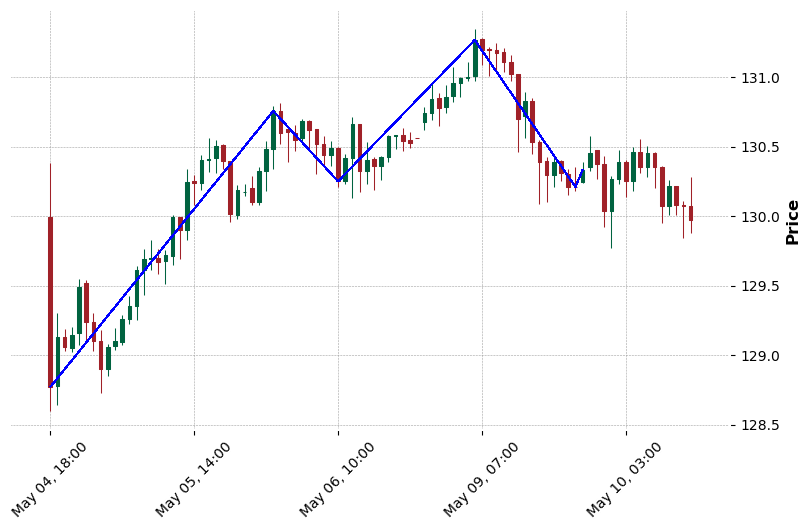

up end


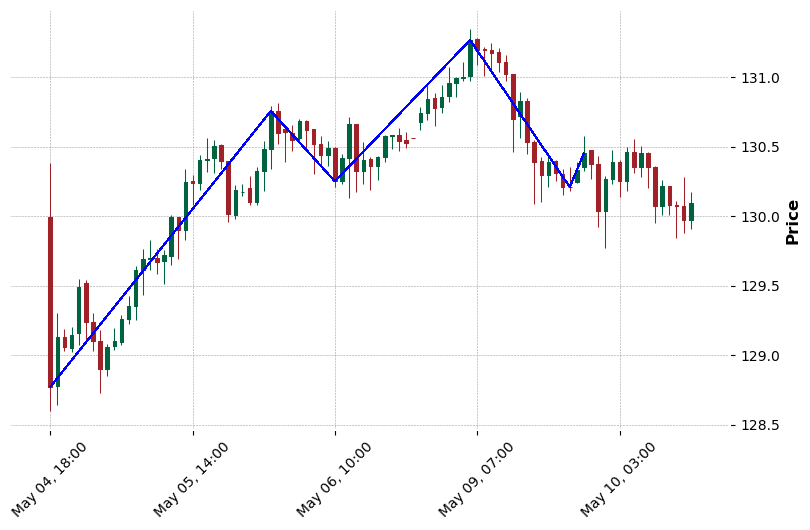

up end


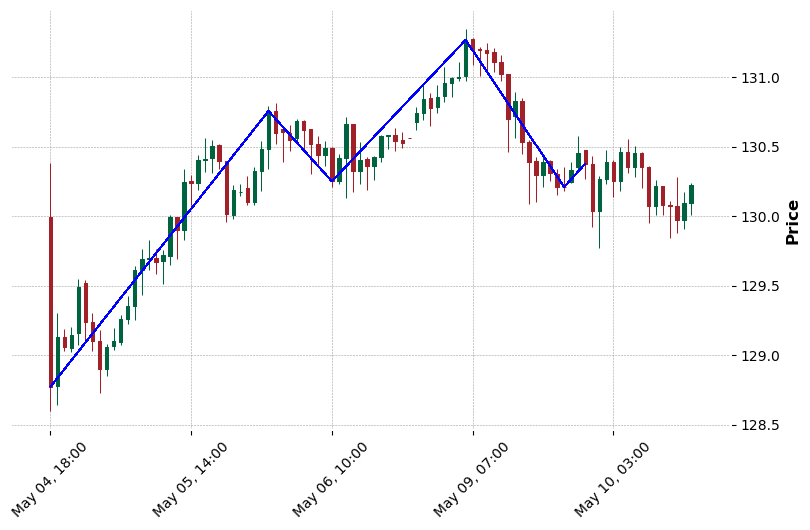

up end


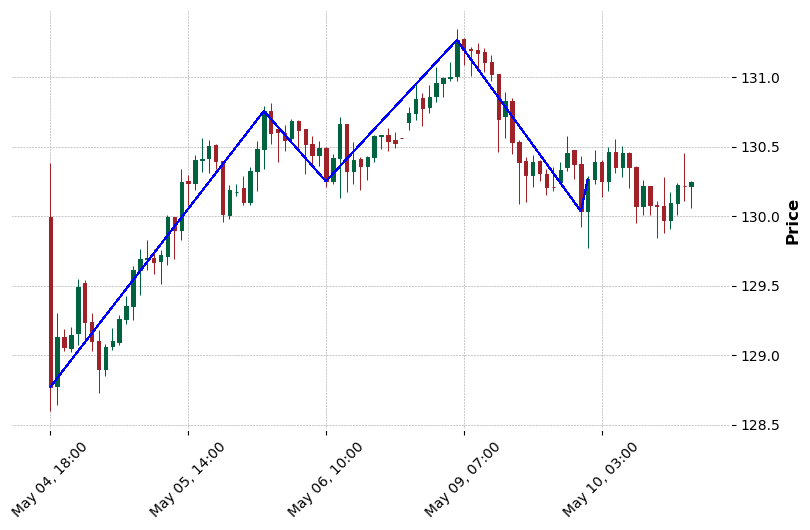

up end


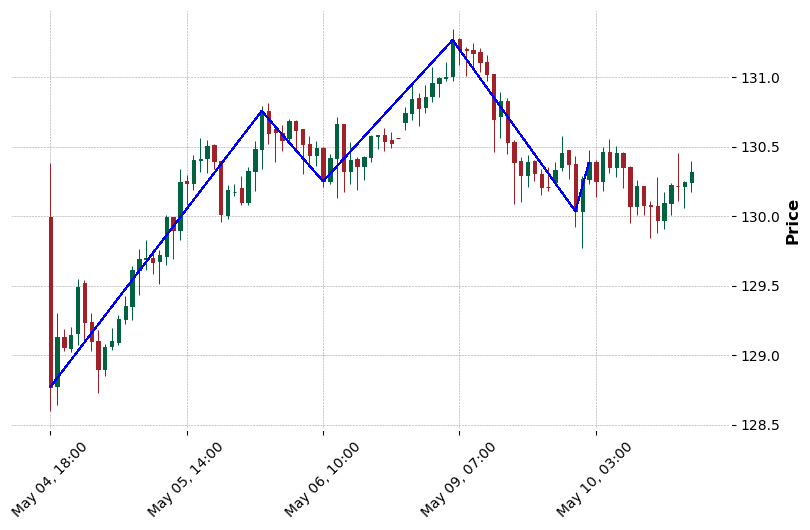

up end


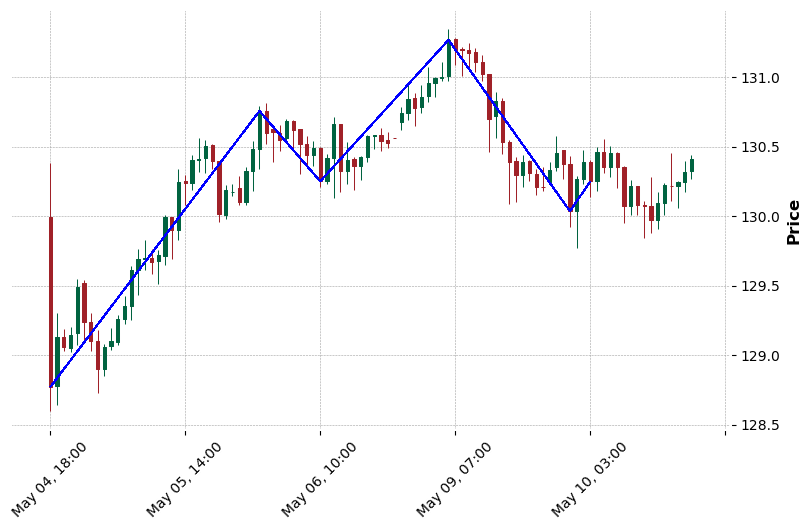

up end


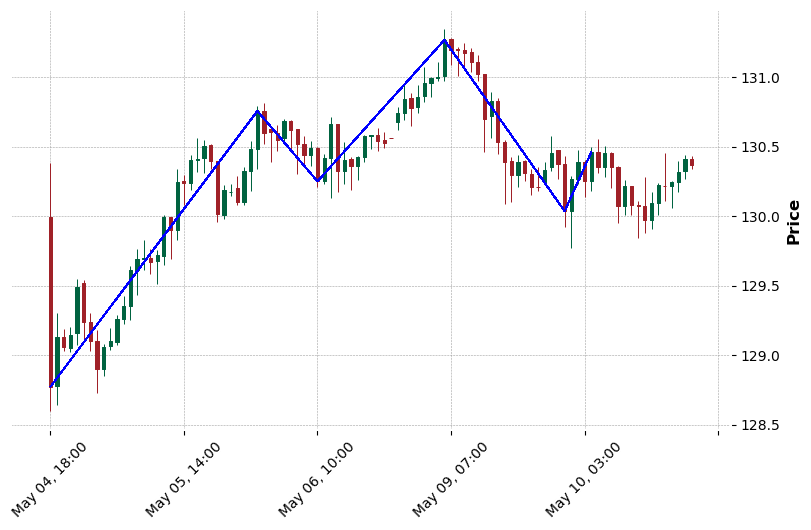

In [7]:
price = df['close'].copy()
for i in range(2000, 4000):
    
     current_pat, current_idx, start, end = find_peak(price, i, 10)
     peak_lines = [(price.index[current_idx[i]], current_pat[i]) for i in range(len(current_pat))]
     trend = find_trend(current_pat)
     # print(current_pat)
    
     if trend == 'up end': # up, dowm, up end, down end ,is not False
          print(trend)
          mpf.plot(df.iloc[start:i+15], type='candle', style='charles',
               alines=dict(alines=peak_lines,colors=['blue'], linewidths=0.8),
               figsize=(10, 6))